In [1]:
# [Input Vars]
#   1. <string> PATH_TO_DESIRED_LOCATION: It should be the directory containing (1) images/ (2) train.txt (3) test.txt (4) val.txt

# [Output Vars]
#   1. <ndarray> np_train_txt: It contains both the directory to a specific image and the related label.
#   2. <ndarray> np_test_txt: It contains both the directory to a specific image and the related label.
#   3. <ndarray> np_val_txt: It contains both the directory to a specific image and the related label.
import pandas as pd
import numpy as np
def read_metadata_files(PATH_TO_DESIRED_LOCATION):
    # train.txt
    train_txt = pd.read_csv(PATH_TO_DESIRED_LOCATION+"train.txt", sep=" ")
    NP_TRAIN_TXT = np.array(train_txt)
    
    # test.txt
    test_txt = pd.read_csv(PATH_TO_DESIRED_LOCATION+"test.txt", sep=" ")
    NP_TEST_TXT = np.array(test_txt)
    
    # val.txt
    val_txt = pd.read_csv(PATH_TO_DESIRED_LOCATION+"val.txt", sep=" ")
    NP_VAL_TXT = np.array(val_txt)
    
    print(f"[Check] There are {NP_TRAIN_TXT.shape[0]} pairs in train.txt.")
    print(f"[Check] There are {NP_TEST_TXT.shape[0]} pairs in test.txt.")
    print(f"[Check] There are {NP_VAL_TXT.shape[0]} pairs in val.txt.\n")
    
    return NP_TRAIN_TXT, NP_TEST_TXT, NP_VAL_TXT

In [2]:
################
# Zero Padding #
################

#[Input Vars]
#  1. <ndarray> X: Unpadded image. The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <int> pad: expected number of pads on each side. The shape is (n_H_prev + 2 * pad, n_W_prev + 2 * pad, n_C_prev).
#
#[Output Vars]
#  1. <ndarray> X_pad: Padded image.

import numpy as np

def __zero_pad(X, pad):
    X_pad = np.pad(X, ((pad, pad), (pad, pad),(0,0)), "constant", constant_values = 0)
    return X_pad

In [3]:
####################
# Conv Single Step #
####################

#[Input Vars]
#  1. <ndarray> a_slice_prev: slice of previous feature maps. The shape is (f, f, n_C_prev).
#  2. <ndarray> K: A single weight matrix (kernel). The shape is (f, f, n_C_prev).
#  3. <ndarray> b: A single bias term. The shape is (1, 1, 1).
#
#[Output Vars]
#  1. <float> Z: a scalar derived from convolution operation.

import numpy as np

def __conv_single_step(s_slice, K, b):
    
    S = np.multiply(s_slice, K)
    Z = np.sum(S)
    Z = Z + float(b)
    
    return Z

In [4]:
############################
# Conv Forward Propagation #
############################

#[Input Vars]
#  1. <ndarray> S_prev: The previous feature maps (after activation and pooling). The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <ndarray> K: Kernels in a layer. The shape is (f, f, n_C_prev, n_C).
#  3. <ndarray> b: biases in a layer. THe shape is (1, 1, 1, n_C).
#  4. <dictionary> hparam: this contains hyper parameters like "pad" and "stride".
#
#[Output Vars]
#  1. <ndarray> C: This would be the feature map in the next layer (but before activation). The shape is (n_H, n_W, n_C).
#  2. <dictionary> cache: Cache the values needed for backward propagation.

import numpy as np

def conv_forward(S_prev, K, b, hparam):
    
    # 1. Retrieve shape of A_prev. We need this to compute the shape of the feature map in the next layer.
    (n_H_prev, n_W_prev, n_C_prev) = S_prev.shape
    
    # 2. Retrieve shape of K. We also need this (i.e. f) to compute the shape of the feature map in the next layer.
    (f, f, n_C_prev, n_C) = K.shape
    
    # 3. Retrieve info. from hyper parameters. We need them to compute the shape of the feature map in the next layer, too.
    stride = hparam["stride"]
    pad = hparam["pad"]
    
    # 4. With info from 1. ~ 3., we can compute the dimension for the feature map in the next layer.
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    # 5. Initialize feature maps in the next layer with zeros. Note #Kernel is equal to #Channel of the feature map.
    C = np.zeros((n_H, n_W, n_C))
    
    # 6. Pad S_prev
    S_prev_pad = __zero_pad(S_prev, pad)
    
    # 7. Do Cross-Relation Operation. Note the shape of the output feature map would be (n_H, n_W, n_C).
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                
                # Define the corners in the S_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                
                # Get the slice.
                S_prev_slice = S_prev_pad[vert_head:vert_tail, hori_head:hori_tail, :]
                
                # Feed it into __conv_single_step(a_slice, K, b). Note we use one kernel and one bias term at once.
                C[h, w, c] = __conv_single_step(S_prev_slice, K[:,:,:,c], b[:,:,:,c])
    
    # 8. Check if the output feature map have the valid shape.
    assert(C.shape == (n_H, n_W, n_C))
    
    # 9. Store the cache for backward propagation
    cache = (S_prev, K, b, hparam)
    
    return C, cache

In [5]:
############################
# Pool Forward Propagation #
############################

#[Input Vars]
#  1. <ndarray> A_prev: The previous feature maps (after activation). The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <dictionary> hparam: It contains "f" and "stride".
#  3. <string> mode: Switch between "maxpooling" and "avgpooling". The shape is (n_H, n_W, n_C). (n_C = n_C_prev)
#
#[Output Vars]
#  1. <ndarray> S: The output feature map after pooling operation.

import numpy as np

def pool_forward(A_prev, hparam, mode = "maxpooling"):
    # 1. Retrieve shape of A_prev.
    (n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # 2. Retrieve info from hyper parameter
    f = hparam["f"]
    stride = hparam["stride"]

    # 3. Define the shape of output of pooling operation.
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev

    # 4. Initialize the output feature map after pooling operation with zeros.
    S = np.zeros((n_H, n_W, n_C))
    
    # 5. Do Pooling Operation
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                
                # Define the corners in the A_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                
                # Get the slice. (Note that there's only one channel involved. Not like conv_forward)
                A_prev_slice = A_prev[vert_head:vert_tail, hori_head:hori_tail, c]
                
                # Pooling operation
                if mode == "maxpooling":
                    S[h, w, c] = np.max(A_prev_slice)
                elif mode == "avgpooling":
                    S[h, w, c] = np.mean(A_prev_slice)
                    
    # 6. Check if the output feature map have the valid shape.
    assert(S.shape == (n_H, n_W, n_C))
    
    # 7. Store the cache for backward propagation
    cache = (A_prev, hparam)
    
    return S, cache

In [6]:
#############################
# Conv Backward Propagation #
#############################

#[Input Vars]
#  1. <ndarray> dC: gradient of the cost with respect to the output of the conv layer (C). The shape is (n_H, n_W, n_C).
#  2. <dictionary> cache: Cache of output of conv_forward()
#
#[Output Vars]
#  1. <ndarray> dS_prev: gradient of the cost w.r.t. the input of the conv layer (S). The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <ndarray> dK: gradient of the cost w.r.t. the weights of the conv layer (K). The shape is (f, f, n_C_prev, n_C).
#  3. <ndarray> db: gradient of the cost w.r.t. the biases of the conv layer (b). The shape is (1, 1, 1, n_C).

def conv_backward(dC, cache):
    
    # 1. Retrieve info. from cache.
    (S_prev, K, b, hparam) = cache
    
    # 2. Retrieve the shape of S_prev.
    (n_H_prev, n_W_prev, n_C_prev) = S_prev.shape
    
    # 3. Retrieve the shape of Kernel.
    (f, f, n_C_prev, n_C) = K.shape
    
    # 4. Retieve info. from hyper parameters.
    stride = hparam["stride"]
    pad = hparam["pad"]
    
    # 5. Retrieve the shape of dC
    (n_H, n_W, n_C) = dC.shape
    
    # 6. Initialize dS_prev, dK, db with the correct shapes.
    dS_prev = np.zeros((n_H_prev, n_W_prev, n_C_prev))
    dK = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    
    # 7. Pad dS_prev and S_prev
    S_prev_pad = __zero_pad(S_prev, pad)
    dS_prev_pad = __zero_pad(dS_prev, pad)
    
    # 8. Do backward pass operation
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                                
                # Define the corners in the A_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                    
                # Get the slice.
                S_prev_slice = S_prev_pad[vert_head:vert_tail, hori_head:hori_tail, :]
                
                # Update Gradients (dS_prev, dK, db) for the window
                dS_prev_pad[vert_head:vert_tail, hori_head:hori_tail, :] += K[:,:,:,c] * dC[h, w, c]
                dK[: , :, :, c] += S_prev_slice * dC[h, w, c]
                db[: , :, :, c] += dC[h, w, c]
                
    # 9. Unpad dS_prev_pad
    if (pad == 0):
        dS_prev = dS_prev_pad
    else:
        dS_prev[:, :, :] = dS_prev_pad[pad:-pad, pad:-pad, :]
    
    
    # 10 Check the validity of the shape
    assert (dS_prev.shape == (n_H_prev, n_W_prev, n_C_prev))
    
    return dS_prev, dK, db

In [7]:
############################
# Max Pool Backward helper #
############################

import numpy as np

def __create_mask_from_window(s):
    mask = (s == np.max(s))
    return mask

############################
# Avg Pool Backward helper #
############################

def __distribute_value(ds, shape):
    
    # 1. Retrieve dimensions from shape
    (n_H, n_W) = shape
    
    # 2. Compute the value to distribute on the matrix
    average = ds / (n_H * n_W)
    
    # 3. Create a matrix where each entry is the avg. value.
    a = np.ones(shape) * average
    return a

In [8]:
#############################
# Pool Backward Propagation #
#############################

#[Input Vars]
#  1. <ndarray> dS: gradient of cost w.r.t. the output of the pooling layer. The shape is the same as the shape of S.
#  2. <dictionary> cache: It contaions the output from the forward pass.
#  3. <string> mode: Switch between "maxpooling" and "avgpooling".
#
#[Output Vars]
#  1. <ndarray> dA_prev: gradient of cost w.r.t. the input of the pooling layer. The shape is the same as the shape of A_prev.

import numpy as np

def pool_backward(dS, cache, mode = "maxpooling"):
    
    # 1. Retrieve info. from cache
    (A_prev, hparam) = cache
    
    # 2. Retrieve hyper parameters
    stride = hparam["stride"]
    f = hparam["f"]
    
    # 3. Retrieve the shapes of A_prev and dS
    n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    n_H, n_W, n_C = dS.shape
    
    # 4. Initialize dA_prev with zeros.
    dA_prev = np.zeros((n_H_prev, n_W_prev, n_C_prev))
    
    # 5. Do Backward Pass Operation
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                                
                # Define the corners in the A_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                
                # Compute the backward propagation in both modes
                if mode == "maxpooling":
                    # Use the corners and the specific "c" tp defome the current slice of A_prev
                    A_prev_slice = A_prev[vert_head:vert_tail, hori_head:hori_tail, c]
                    
                    # Create the mask from A_prev_slice
                    mask = __create_mask_from_window(A_prev_slice)
                    
                    # Update dA_prev
                    dA_prev[vert_head:vert_tail, hori_head:hori_tail, c] += np.multiply(mask, dS[h, w, c])
                elif mode == "avgpooling":
                    # Get the entry ds from dS
                    ds = dS[h, w, c]
                    
                    # Define the shape of the kernel as (f, f).
                    shape = (f, f)
                    
                    # Distribute it (ds) to the correct slice of dA_prev
                    dA_prev[vert_head:vert_tail, hori_head:hori_tail, c] += __distribute_value(ds, shape)
    
    # 6. Check the dA_prev has the valid shape 
    assert (dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [96]:
########################################
# Actication Functions for Propagation #
########################################

# [Input Vars]
#   1. <ndarray> Z
#
# [Output Vars]
#   1. <ndarray> A

import numpy as np

def activation_forward(Z, mode):
    if mode == "sigmoid":
        A = 1/(1 + np.exp(-Z))
    elif mode == "relu":
        A = Z * (Z > 0)
    return A

def activation_backward(X, mode):
    if mode == "sigmoid":
        D_Z_local = np.multiply(1 - X, X)
    elif mode == "relu":
        D_Z_local = X
        D_Z_local[X<=0] = 0
        D_Z_local[X>0] = 1
    return D_Z_local

# [Input Vars]
#   1. <ndarray> A
#
# [Output Vars]
#   1. <ndarray> Y_pred
def __softmax(A):
    Y_pred = np.exp(A)/np.sum(np.exp(A))
#    Y_pred = np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)))
    return Y_pred

In [103]:
x = np.array([[0.49833778,0.4997031,0.50449409,0.50825198 ,0.5010792,0.49661981,0.50677993,0.50785792,0.49874496,0.50546494,0.49378802 ,0.50478438 ,0.5085074 , 0.50068528 ,0.48819664, 0.50271488, 0.50013962, 0.50252153, 0.50030132 ,0.49636748 ,0.49688169, 0.48623888 ,0.49517905 ,0.49206075 ,0.49318144 ,0.4998719 , 0.50700566, 0.50477959, 0.50963955 ,0.50955469 ,0.50568908 ,0.48404442, 0.50541627 ,0.50910356 ,0.50062134 ,0.50014381 ,0.50087147 ,0.50807964 ,0.49085042 ,0.50534322, 0.4922645 , 0.49861192 ,0.49566855 ,0.4913313  ,0.51591349 ,0.50007738, 0.50908724, 0.4906912 ,0.50117277, 0.50070772]])
sum(sum(__softmax(x)))

0.9999999999999999

In [75]:
# Initiallize the Kernels, Biases, and hparams

def Initialize_Parameters(low, high):
    
    # C1
    K_C1 = np.random.uniform(low=low, high=high, size=(5, 5, 3, 6))
    b_C1 = np.random.uniform(low=low, high=high, size=(1, 1, 1, 6))
    hparam_C1 = {"stride": 1, "pad": 0}

    # S2
    hparam_S2 = {"f": 2, "stride": 2}

    # C3
    K_C3 = np.random.uniform(low=low, high=high, size=(5, 5, 6, 16))
    b_C3 = np.random.uniform(low=low, high=high, size=(1, 1, 1, 16))
    hparam_C3 = {"stride":1, "pad": 0}

    # S4
    hparam_S4 = {"f": 2, "stride": 2}

    # C5
    K_C5 = np.random.uniform(low=low, high=high, size=(29, 29, 16, 120))
    b_C5 = np.random.uniform(low=low, high=high, size=(1, 1, 1, 120))
    hparam_C5 = {"stride":1, "pad": 0}

    # W7
    W7 = np.random.uniform(low=low, high=high, size=(120, 84))

    # W8
    W8 = np.random.uniform(low=low, high=high, size=(84, 50))
    
    return K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8

In [104]:
################################
# LeNet5 - Forward Propagation #
################################

def LeNet5_forward(X, K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8, pool_mode = "avgpooling", act_mode = "sigmoid"):
    
    #if 0 in X: print("Zero in X")
    #print(X.shape)
    #print(X)
    X_C1, cache_C1 = conv_forward(X, K_C1, b_C1, hparam_C1)
    #if 0 in X: print("Zero in X_C1")
    X_A1 = activation_forward(X_C1, act_mode)
    #if 0 in X: print("Zero in X_A1")
    X_S2, cache_S2 = pool_forward(X_A1, hparam_S2, pool_mode)
    #if 0 in X: print("Zero in X_S2")
    X_C3, cache_C3 = conv_forward(X_S2, K_C3, b_C3, hparam_C3)
    #if 0 in X: print("Zero in X_C3")
    X_A3 = activation_forward(X_C3, act_mode)
    #if 0 in X: print("Zero in X_A3")
    X_S4, cache_S4 = pool_forward(X_A3, hparam_S4, pool_mode)
    #if 0 in X: print("Zero in X_S4")
    X_C5, cache_C5 = conv_forward(X_S4, K_C5, b_C5, hparam_C5)
    #if 0 in X: print("Zero in X_C5")
    X_A5 = activation_forward(X_C5, act_mode)
    #if 0 in X: print("Zero in X_A5")
    X_A6 = X_A5.reshape(1, 120)
    #if 0 in X: print("Zero in X_A6")
    X_Z7 = np.dot(X_A6, W7)
    #if 0 in X: print("Zero in X_Z7")
    X_A7 = activation_forward(X_Z7, act_mode)
    #if 0 in X: print("Zero in X_A7")
    X_Z8 = np.dot(X_A7, W8)
    #if 0 in X: print("Zero in X_Z8")
    X_A8 = activation_forward(X_Z8, act_mode)

    Y_pred = __softmax(X_A8)
    #if 0 in X: print("Zero in Y_pred")
    
    return cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred

In [105]:
def cross_entropy(Y_pred, Y_truth):
    Error = (-1 * Y_truth * np.log(Y_pred)).sum()
    return Error

In [106]:
#################################
# LeNet5 - Backward Propagation #
#################################

def LeNet5_backward(cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred, Y_truth, pool_mode = "avgpooling", act_mode = "sigmoid"):
    
    D_A8 = Y_pred - Y_truth
    
    D_Z8_local = activation_backward(X_A8, act_mode)
    D_Z8 = np.multiply(D_Z8_local, D_A8)
    
    D_W8 = np.outer(X_A7, D_Z8)
    D_A7 = np.dot(D_Z8, D_W8.T)
    
    D_Z7_local = activation_backward(X_A7, act_mode)
    D_Z7 = np.multiply(D_Z7_local, D_A7)
    
    D_W7 = np.outer(X_A6, D_Z7)
    D_A6 = np.dot(D_Z7, D_W7.T)
    D_A5 = D_A6.reshape(1,1,120)
    
    D_C5_local = activation_backward(X_A5, act_mode)
    D_C5 = np.multiply(D_C5_local, D_A5)
    D_S4, D_K_C5, D_b_C5 = conv_backward(D_C5, cache_C5)
    D_A3 = pool_backward(D_S4, cache_S4, pool_mode)
    
    D_C3_local = activation_backward(X_A3, act_mode)
    D_C3 = np.multiply(D_C3_local, D_A3)
    D_S2, D_K_C3, D_b_C3 = conv_backward(D_C3, cache_C3)
    D_A1 = pool_backward(D_S2, cache_S2, pool_mode)
    
    D_C1_local = activation_backward(X_A1, act_mode)
    D_C1 = np.multiply(D_C1_local, D_A1)
    D_X, D_K_C1, D_b_C1 = conv_backward(D_C1, cache_C1)
    
    return D_W8, D_W7, D_K_C5, D_b_C5, D_K_C3, D_b_C3, D_K_C1, D_b_C1

In [119]:
def update_trainable_parameters(lr, D_W8, W8, D_W7, W7, D_K_C5, K_C5, D_b_C5, b_C5, D_K_C3, K_C3, D_b_C3, b_C3, D_K_C1, K_C1, D_b_C1, b_C1):
    
    W8 = W8 - lr * D_W8
    W7 = W7 - lr * D_W7
    K_C5 = K_C5 - lr * D_K_C5
    b_C5 = b_C5 - lr * D_b_C5
    K_C3 = K_C3 - lr * D_K_C3
    b_C3 = b_C3 - lr * D_b_C3
    K_C1 = K_C1 - lr * D_K_C1
    b_C1 = b_C1 - lr * D_b_C1
    
    return W8, W7, K_C5, b_C5, K_C3, b_C3, K_C1, b_C1

In [120]:
import time


# [Output Vars]
#   1. <int> top1_accuracy
#   2. <int> top5_accuracy
def top_accuracy(Metadata, Name, K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8, pool_mode, act_mode):
    
    num_top1_pred = 0
    num_top5_pred = 0
    len_dataset = len(Metadata)
    
    tic = time.time()
    for i in range(len_dataset):
        # 1. Read a specific image in RGB format.
        img = cv.imread(ROOT_PATH + Metadata[i][0])
        img_label = Metadata[i][1]
    
        # 2. Resize the image to a fixed size (128, 128)
        img_resize = cv.resize(img, (128, 128))
        X = img_resize / 255.0
        
        cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred = LeNet5_forward(X, K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8, pool_mode, act_mode)
        
        # 4. Grab top 5 predictions.
        top_1, top_2, top_3, top_4, top_5 = grab_top_5_predictions(Y_pred)
        
        # 5. Check if the label is the top 1 prediction.
        if img_label == top_1: num_top1_pred = num_top1_pred + 1

        # 6. Check if the label is in the top 5 predictions
        if img_label in [top_1, top_2, top_3, top_4, top_5]: num_top5_pred = num_top5_pred + 1
         
        print(f"top5 are {top_1, top_2, top_3, top_4, top_5}, answer is {img_label}")
        
    top1_accuracy = round(num_top1_pred/len_dataset*100, 2)
    top5_accuracy = round(num_top5_pred/len_dataset*100, 2)
    print(f"[Result of {Name}] The top-1 accuracy is {top1_accuracy} %")
    print(f"[Result of {Name}] The top-5 accuracy is {top5_accuracy} %")
    
    return top1_accuracy, top5_accuracy

In [121]:
# [Input Vars]
#   1. <ndarray> Y_pred: It's a 1-D ndarray which contains the possibilities of the predictions.

# [Output Vars]
#   1. <int> top_1: The 1st likely breed among those 50 breeds.
#   2. <int> top_2: The 2nd likely breed among those 50 breeds.
#   3. <int> top_3: The 3rd likely breed among those 50 breeds.
#   4. <int> top_4: The 4th likely breed among those 50 breeds.
#   5. <int> top_5: The 5th likely breed among those 50 breeds.
import numpy as np
def grab_top_5_predictions(Y_pred):

    top_1 = Y_pred.argmax()
    Y_pred[0][top_1] = 0

    top_2 = Y_pred.argmax()
    Y_pred[0][top_2] = 0
    
    top_3 = Y_pred.argmax()
    Y_pred[0][top_3] = 0

    top_4 = Y_pred.argmax()
    Y_pred[0][top_4] = 0

    top_5 = Y_pred.argmax()

    return top_1, top_2, top_3, top_4, top_5

In [ ]:
ROOT_PATH = "C:/Users/USER/Desktop/Projects/Github_Repo/AI/DeepLearning/__HW1_DATA/"
NP_TRAIN_TXT, NP_TEST_TXT, NP_VAL_TXT = read_metadata_files(ROOT_PATH)

Metadata = NP_TRAIN_TXT

import cv2 as cv
import numpy as np
import time

# Initialize Parameters
K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8 = Initialize_Parameters(-0.01, 0.01)
Epoch = 10
lr = 0.001

# 0. Shuffle the training dataset.
Length_TRAIN = len(Metadata)
random_index = np.arange(Length_TRAIN)
np.random.shuffle(random_index)
print(random_index[:500])

val_top1, val_top5 = top_accuracy(NP_TRAIN_TXT[:100], "Val", K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8, "avgpooling", "sigmoid")
print(f"[Epoch: {0} || ({0}/{0})] The val top-1 Acc. is {val_top1}, val top-5 Acc. is {val_top5}.\n")

loss_list = []
for epoch in range(Epoch):
    tmp_list = []
    counter = 0
    for i in random_index[:500]:
    
        # 1. Read a specific image in RGB format.
        img = cv.imread(ROOT_PATH + Metadata[i][0])
        #print(img.shape)
        img_label = Metadata[i][1]
    
        # 2. Resize the image to a fixed size (128, 128)
        img_resize = cv.resize(img, (128, 128))
        X = img_resize / 255.0
        Y_truth = np.zeros((1,50))
        Y_truth[0][img_label] = 1
    
        # 3. Forward Pass
        tic = time.time()
        cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred = LeNet5_forward(X, K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8, "avgpooling", "sigmoid")
        toc = time.time()
        #print(f"[Epoch: {epoch} || ({counter+1}/{Length_TRAIN})] [Forward Propagation] Spend {round(toc-tic,2)} sec.")
        
        # 4. Cross Entropy Loss
        tmp_list.append(cross_entropy(Y_pred, Y_truth))
        
        # 5. Backward Pass
        tic = time.time()
        D_W8, D_W7, D_K_C5, D_b_C5, D_K_C3, D_b_C3, D_K_C1, D_b_C1 = LeNet5_backward(cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred, Y_truth, "avgpooling", "sigmoid")
        toc = time.time()
        #print(f"[Epoch: {epoch} || ({counter+1}/{Length_TRAIN})] [Backward Propagation] Spend {round(toc-tic,2)} sec.")
        
        # 6. Update Weights
        W8, W7, K_C5, b_C5, K_C3, b_C3, K_C1, b_C1 = update_trainable_parameters(lr, D_W8, W8, D_W7, W7, D_K_C5, K_C5, D_b_C5, b_C5, D_K_C3, K_C3, D_b_C3, b_C3, D_K_C1, K_C1, D_b_C1, b_C1)    
    
        print(f"[Epoch: {epoch} || ({counter+1}/{Length_TRAIN})] [Loss] {cross_entropy(Y_pred, Y_truth)}\n[Check 1st D_K]:\n{D_K_C1[:,:,0,0]}\n")
        counter = counter + 1
        
        # 7. Measure Accuracy
        #if counter % 1 == 0:
    tic = time.time()
    val_top1, val_top5 = top_accuracy(NP_VAL_TXT[:100], "Val", K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8, "avgpooling", "sigmoid")
    print(f"[Epoch: {epoch} || ({counter+1}/{500})] The val top-1 Acc. is {val_top1}, val top-5 Acc. is {val_top5}.\n")
    toc = time.time()
        #print(f"[Epoch: {epoch} || ({counter+1}/{Length_TRAIN})] [Measure Accuracy] Spend {round(toc-tic,2)} sec.")

    loss_list.append(np.mean(tmp_list))

[Check] There are 63324 pairs in train.txt.
[Check] There are 449 pairs in test.txt.
[Check] There are 449 pairs in val.txt.

[23072 30141 35804 40953 10759 10825 43119 57896 60636 24896 25106 24002
 18222 37928  1306 31351  2545 44296 22476 21570  5304 43723 50775 32259
 49483  9509 47219  8134 57072 54851  8649 57611 25132 17927 58360  7279
 12310  5694 47192 49239 21334 58851 52849 44436 16074 23523 22930  6044
 59785 60167 16615 41673 39482 15226 33820  5319 60775 61733  5646 58266
 52394 48333 55435  5375 17770 55463 37170  1480 22325 13023 39218 63190
  5425 22120 51221 43424 44840  9436 31702  5408 44538 28223  9875 57098
 56646 22640  9088 10721 61651  3350 45601 30329 38712 53570 26787 34256
 43606 43444 43169 14691 35732 33506 39620 35956 42100 23221 62027 10858
   860 19162 19725  9206  2354 44274 34603  1396  4968  8493 39166  9841
 34340 28610 45429 37064 44162 56904 20495 48665 14444 11807 55047  3772
 26566 59358 23028 53822 54974 61588 34026 27510 24105 17534 43116 3961

[Epoch: 0 || (3/63324)] [Loss] 3.9157343689518016
[Check 1st D_K]:
[[7.15322051e-06 6.59183785e-06 6.06918377e-06 5.94790382e-06
  6.07167137e-06]
 [7.14857836e-06 6.47191975e-06 5.96655160e-06 5.70766006e-06
  5.81933187e-06]
 [7.14739420e-06 6.49894530e-06 6.03994704e-06 5.55614147e-06
  5.45458872e-06]
 [7.00819563e-06 6.49927387e-06 6.11637802e-06 5.51784111e-06
  5.24826206e-06]
 [6.80797844e-06 6.51107810e-06 6.27457887e-06 5.64470947e-06
  5.30948487e-06]]

[Epoch: 0 || (4/63324)] [Loss] 3.9185197213425025
[Check 1st D_K]:
[[6.97139021e-06 7.07766781e-06 6.84901732e-06 6.49262471e-06
  6.10355408e-06]
 [7.45614682e-06 7.33202989e-06 7.07946623e-06 6.67347752e-06
  6.24653168e-06]
 [7.83692913e-06 7.46653919e-06 7.27544659e-06 6.98989486e-06
  6.56916836e-06]
 [7.67351609e-06 7.25828389e-06 7.20181833e-06 7.12885225e-06
  6.79420330e-06]
 [7.42278056e-06 7.04444685e-06 7.12861853e-06 7.17750457e-06
  6.99240416e-06]]

[Epoch: 0 || (5/63324)] [Loss] 3.912889015236284
[Check 1st D_

[Epoch: 0 || (21/63324)] [Loss] 3.91377113869956
[Check 1st D_K]:
[[7.36146372e-06 7.39875826e-06 7.34750321e-06 7.14265421e-06
  6.91874636e-06]
 [7.02575956e-06 7.03476895e-06 7.08640711e-06 7.03172312e-06
  6.95509446e-06]
 [6.75890464e-06 6.71817727e-06 6.80999016e-06 6.86887794e-06
  6.91344548e-06]
 [6.56853651e-06 6.47902070e-06 6.59338807e-06 6.70641859e-06
  6.80438783e-06]
 [6.47854664e-06 6.34738589e-06 6.42740007e-06 6.51247551e-06
  6.61321764e-06]]

[Epoch: 0 || (22/63324)] [Loss] 3.914801031956333
[Check 1st D_K]:
[[4.84036395e-06 4.78375671e-06 4.32013087e-06 3.69377399e-06
  3.55737207e-06]
 [5.04544200e-06 4.99989433e-06 4.57734038e-06 4.10438446e-06
  4.02319329e-06]
 [5.12495790e-06 5.07595231e-06 4.76114051e-06 4.55093073e-06
  4.45899589e-06]
 [5.10681962e-06 5.22693470e-06 5.10677578e-06 4.95335439e-06
  4.95781024e-06]
 [5.14219793e-06 5.27573344e-06 5.64292957e-06 5.53821639e-06
  5.55379948e-06]]

[Epoch: 0 || (23/63324)] [Loss] 3.9090572146729317
[Check 1st D

[Epoch: 0 || (39/63324)] [Loss] 3.922804277239843
[Check 1st D_K]:
[[3.81612088e-06 3.95079461e-06 3.82852942e-06 3.82133762e-06
  3.75960295e-06]
 [3.82692844e-06 3.97961883e-06 3.87137885e-06 3.85998792e-06
  3.65959130e-06]
 [3.82062088e-06 4.04304787e-06 3.96708338e-06 4.02438518e-06
  3.93119724e-06]
 [4.27247672e-06 4.48678937e-06 4.38387730e-06 4.40052941e-06
  4.41678484e-06]
 [4.53520193e-06 4.76997908e-06 4.67756429e-06 4.74158559e-06
  4.80172328e-06]]

[Epoch: 0 || (40/63324)] [Loss] 3.909950783086451
[Check 1st D_K]:
[[9.34392106e-06 9.28831897e-06 9.30413969e-06 9.38271190e-06
  9.29915577e-06]
 [9.31769314e-06 9.28912755e-06 9.39274205e-06 9.54646182e-06
  9.48665701e-06]
 [9.25706859e-06 9.24131399e-06 9.45168219e-06 9.65798941e-06
  9.61175075e-06]
 [9.30151602e-06 9.26780585e-06 9.51133602e-06 9.73387860e-06
  9.73686445e-06]
 [9.43302845e-06 9.37992808e-06 9.62524353e-06 9.87638808e-06
  9.87374407e-06]]

[Epoch: 0 || (41/63324)] [Loss] 3.9105049617110827
[Check 1st 

[Epoch: 0 || (57/63324)] [Loss] 3.9210346628880597
[Check 1st D_K]:
[[7.03060249e-06 6.99834333e-06 6.84503199e-06 6.52799288e-06
  6.27980166e-06]
 [6.96241991e-06 6.92812001e-06 6.73887352e-06 6.47117627e-06
  6.23776289e-06]
 [6.99138249e-06 6.91842231e-06 6.69041820e-06 6.48350287e-06
  6.22094220e-06]
 [7.01278768e-06 6.88084562e-06 6.63188974e-06 6.47764241e-06
  6.20464718e-06]
 [7.11451881e-06 6.91815403e-06 6.65545637e-06 6.52340785e-06
  6.18483687e-06]]

[Epoch: 0 || (58/63324)] [Loss] 3.9197606213389014
[Check 1st D_K]:
[[3.17233153e-06 2.75413560e-06 2.28775131e-06 2.06429190e-06
  1.89837121e-06]
 [2.80006503e-06 2.47518932e-06 2.16451903e-06 2.08899702e-06
  2.05854282e-06]
 [2.45742447e-06 2.19571537e-06 2.05227814e-06 2.01978973e-06
  2.06964716e-06]
 [2.26074474e-06 2.01677071e-06 1.95681162e-06 1.85668091e-06
  1.86778649e-06]
 [2.16506991e-06 1.90653436e-06 1.77416989e-06 1.59195367e-06
  1.59348593e-06]]

[Epoch: 0 || (59/63324)] [Loss] 3.9095484281224953
[Check 1s

[Epoch: 0 || (75/63324)] [Loss] 3.909125982792563
[Check 1st D_K]:
[[4.49989793e-06 4.66670122e-06 4.83029052e-06 4.57447782e-06
  4.30670923e-06]
 [4.65846358e-06 4.82932525e-06 4.95558303e-06 4.72751708e-06
  4.46344019e-06]
 [4.80161512e-06 4.94195366e-06 5.02936881e-06 4.88983643e-06
  4.72172510e-06]
 [4.91254891e-06 5.01907181e-06 5.05971817e-06 5.01034208e-06
  4.98068210e-06]
 [4.96441507e-06 5.08440507e-06 5.10232686e-06 5.20068675e-06
  5.25469005e-06]]

[Epoch: 0 || (76/63324)] [Loss] 3.9148926765091328
[Check 1st D_K]:
[[1.59942788e-06 1.95397440e-06 2.17560785e-06 1.95841622e-06
  1.53883552e-06]
 [1.67378092e-06 1.72368531e-06 1.73420785e-06 1.49319543e-06
  1.28710003e-06]
 [1.71856574e-06 1.42494654e-06 1.24112790e-06 1.02788140e-06
  1.10848996e-06]
 [1.82726061e-06 1.24296758e-06 8.96645332e-07 7.22498700e-07
  1.01617862e-06]
 [1.94682340e-06 1.45971609e-06 1.04185637e-06 7.92519210e-07
  1.11552473e-06]]

[Epoch: 0 || (77/63324)] [Loss] 3.9010195166795034
[Check 1st

[Epoch: 0 || (93/63324)] [Loss] 3.912981420621623
[Check 1st D_K]:
[[4.52978148e-07 3.07771383e-07 5.04962543e-07 8.44721284e-07
  1.45860969e-06]
 [6.42001770e-07 5.20862042e-07 6.54523547e-07 8.88744494e-07
  1.41329183e-06]
 [7.78084593e-07 7.44162518e-07 8.58963056e-07 1.00514287e-06
  1.42341317e-06]
 [8.03350715e-07 8.78502686e-07 1.03796642e-06 1.13311249e-06
  1.43513249e-06]
 [7.79489088e-07 9.17014707e-07 1.11951732e-06 1.22685199e-06
  1.46935500e-06]]

[Epoch: 0 || (94/63324)] [Loss] 3.9113752599288683
[Check 1st D_K]:
[[6.09887721e-06 6.18809220e-06 5.96113456e-06 5.61013384e-06
  5.28758938e-06]
 [5.91011458e-06 6.02114843e-06 5.74376519e-06 5.28246280e-06
  4.76784053e-06]
 [5.45779518e-06 5.50477733e-06 5.30550481e-06 4.81118122e-06
  4.27374907e-06]
 [4.87765807e-06 4.87744464e-06 4.78156143e-06 4.34581854e-06
  3.83707878e-06]
 [4.09590943e-06 4.01505630e-06 4.00660617e-06 3.72588520e-06
  3.29712236e-06]]

[Epoch: 0 || (95/63324)] [Loss] 3.909010799230102
[Check 1st 

[Epoch: 0 || (110/63324)] [Loss] 3.9228740519873857
[Check 1st D_K]:
[[-1.39654570e-06 -1.27818619e-06 -1.08413558e-06 -8.34717926e-07
  -6.92960589e-07]
 [-1.74338695e-06 -1.62855931e-06 -1.28729284e-06 -9.51470166e-07
  -8.04039746e-07]
 [-1.79992708e-06 -1.69180966e-06 -1.36582501e-06 -1.08531097e-06
  -9.22042504e-07]
 [-1.83337192e-06 -1.78600130e-06 -1.48679068e-06 -1.23353195e-06
  -1.08245996e-06]
 [-1.82666803e-06 -1.76782566e-06 -1.54608567e-06 -1.31088019e-06
  -1.13632806e-06]]

[Epoch: 0 || (111/63324)] [Loss] 3.9216127256613675
[Check 1st D_K]:
[[ 8.46786553e-07  5.83304336e-07  6.94757665e-08 -5.71320649e-07
  -9.39214424e-07]
 [ 7.42633224e-07  6.41018936e-07  1.11276922e-07 -4.05704976e-07
  -6.75402689e-07]
 [ 5.40689263e-07  4.91307384e-07  8.75933271e-08 -1.68230321e-07
  -4.16895169e-07]
 [ 3.82212632e-07  3.74686483e-07  1.41118031e-07  1.28038498e-07
  -5.07769070e-08]
 [ 2.85074940e-07  2.04571009e-07  2.10634972e-07  3.30937540e-07
   2.24645643e-07]]

[Epoch: 

[Epoch: 0 || (127/63324)] [Loss] 3.9100810377442037
[Check 1st D_K]:
[[3.30114194e-07 4.00580607e-07 3.40045563e-07 2.51524863e-07
  2.67950666e-07]
 [4.89129906e-07 4.62030722e-07 3.19300908e-07 2.22251850e-07
  2.77695932e-07]
 [5.88514692e-07 4.99283186e-07 2.94860147e-07 1.58517142e-07
  2.19640848e-07]
 [5.35248302e-07 5.18682327e-07 3.07953391e-07 9.82155999e-08
  1.13250742e-07]
 [3.59080338e-07 3.93844982e-07 2.68421506e-07 2.49955239e-08
  1.81690628e-09]]

[Epoch: 0 || (128/63324)] [Loss] 3.9176135096377096
[Check 1st D_K]:
[[ 3.12948991e-07  1.50096080e-07  9.31282637e-08  8.40390375e-09
  -4.52604194e-08]
 [ 7.09936572e-07  4.40276123e-07  3.24216779e-07  1.44051824e-07
   3.35905640e-08]
 [ 1.00519620e-06  7.10492536e-07  5.56333690e-07  3.99181974e-07
   2.89337534e-07]
 [ 1.03764679e-06  8.50084772e-07  7.36193360e-07  6.67469367e-07
   5.57187754e-07]
 [ 8.24406353e-07  7.95552520e-07  7.38885046e-07  7.73399030e-07
   6.92494620e-07]]

[Epoch: 0 || (129/63324)] [Loss] 

[Epoch: 0 || (144/63324)] [Loss] 3.9071377168032324
[Check 1st D_K]:
[[-1.04159474e-06 -1.30502783e-06 -1.51661181e-06 -1.55575976e-06
  -1.53306082e-06]
 [-1.30907656e-06 -1.69134797e-06 -1.98460530e-06 -1.94567938e-06
  -1.82470778e-06]
 [-1.44393177e-06 -1.88362808e-06 -2.21949435e-06 -2.14568630e-06
  -1.98282560e-06]
 [-1.44951303e-06 -1.88831055e-06 -2.28676047e-06 -2.23483094e-06
  -2.00812836e-06]
 [-1.37252190e-06 -1.77747653e-06 -2.17410374e-06 -2.13423459e-06
  -1.85278655e-06]]

[Epoch: 0 || (145/63324)] [Loss] 3.915452442108402
[Check 1st D_K]:
[[-6.63642807e-07 -8.09900319e-07 -1.25604073e-06 -1.67825633e-06
  -1.91413527e-06]
 [-6.11988834e-07 -6.56734451e-07 -1.00206289e-06 -1.42939457e-06
  -1.69993747e-06]
 [-6.55929804e-07 -6.23221110e-07 -8.47223320e-07 -1.21487600e-06
  -1.53083944e-06]
 [-6.86752930e-07 -5.91015897e-07 -7.16421388e-07 -1.01222402e-06
  -1.32556389e-06]
 [-7.28335935e-07 -5.80582162e-07 -6.35612204e-07 -8.45890252e-07
  -1.09421219e-06]]

[Epoch: 0

[Epoch: 0 || (161/63324)] [Loss] 3.9096757008398155
[Check 1st D_K]:
[[-3.19127997e-06 -3.33891408e-06 -3.40518860e-06 -3.31738544e-06
  -3.17296376e-06]
 [-2.87733266e-06 -3.00156649e-06 -3.02962103e-06 -2.95359743e-06
  -2.86966996e-06]
 [-2.66200443e-06 -2.79661054e-06 -2.80142758e-06 -2.75634399e-06
  -2.67463069e-06]
 [-2.53765388e-06 -2.61943192e-06 -2.56996610e-06 -2.52420421e-06
  -2.43157808e-06]
 [-2.39091313e-06 -2.42507259e-06 -2.37567878e-06 -2.30983533e-06
  -2.18917947e-06]]

[Epoch: 0 || (162/63324)] [Loss] 3.9063288938126965
[Check 1st D_K]:
[[-4.52209553e-06 -4.28418546e-06 -4.27737545e-06 -4.28202214e-06
  -4.29681461e-06]
 [-4.64258983e-06 -4.45724881e-06 -4.47267326e-06 -4.51004552e-06
  -4.41638858e-06]
 [-4.31187285e-06 -4.25629803e-06 -4.35208894e-06 -4.38356007e-06
  -4.30049461e-06]
 [-3.72049835e-06 -3.77894209e-06 -3.85960122e-06 -3.88103183e-06
  -3.81079566e-06]
 [-3.02056196e-06 -3.12733973e-06 -3.20283467e-06 -3.21301428e-06
  -3.20394860e-06]]

[Epoch: 

[Epoch: 0 || (178/63324)] [Loss] 3.9272691045435537
[Check 1st D_K]:
[[-2.99720105e-06 -3.19623228e-06 -3.40229989e-06 -3.61639446e-06
  -3.68587227e-06]
 [-2.77849346e-06 -2.95294003e-06 -3.10421814e-06 -3.30106728e-06
  -3.48112669e-06]
 [-2.62841201e-06 -2.78614003e-06 -2.90849581e-06 -3.11590974e-06
  -3.39003408e-06]
 [-2.48774652e-06 -2.65599214e-06 -2.75747342e-06 -2.95861625e-06
  -3.27092714e-06]
 [-2.37234235e-06 -2.55008449e-06 -2.64373932e-06 -2.83535575e-06
  -3.10444861e-06]]

[Epoch: 0 || (179/63324)] [Loss] 3.916634066903063
[Check 1st D_K]:
[[-9.23315200e-07 -6.46588349e-07 -7.06164701e-07 -8.10785722e-07
  -8.76297584e-07]
 [-1.43221076e-06 -1.24276764e-06 -1.14498892e-06 -1.13765314e-06
  -1.13178755e-06]
 [-1.97636309e-06 -1.84179574e-06 -1.61448248e-06 -1.48428716e-06
  -1.34103066e-06]
 [-2.40599485e-06 -2.29931504e-06 -2.01879328e-06 -1.82089893e-06
  -1.62613970e-06]
 [-2.81789780e-06 -2.73465477e-06 -2.45140178e-06 -2.24743425e-06
  -2.04383534e-06]]

[Epoch: 0

[Epoch: 0 || (195/63324)] [Loss] 3.9096668126742284
[Check 1st D_K]:
[[-3.24336846e-06 -3.15268422e-06 -3.08196401e-06 -2.87646744e-06
  -2.69696864e-06]
 [-3.48093377e-06 -3.34010323e-06 -3.25884597e-06 -3.01256214e-06
  -2.79896061e-06]
 [-3.68359878e-06 -3.52978946e-06 -3.40637370e-06 -3.13686409e-06
  -2.89789978e-06]
 [-3.59319563e-06 -3.50717656e-06 -3.43944243e-06 -3.28153452e-06
  -3.13196141e-06]
 [-3.38077868e-06 -3.36493627e-06 -3.32936735e-06 -3.25775179e-06
  -3.11910252e-06]]

[Epoch: 0 || (196/63324)] [Loss] 3.9077302471210142
[Check 1st D_K]:
[[-3.35247845e-06 -3.29571103e-06 -3.24328982e-06 -3.27552135e-06
  -3.28282381e-06]
 [-3.28306352e-06 -3.26806754e-06 -3.16851630e-06 -3.18083821e-06
  -3.19635972e-06]
 [-3.30054957e-06 -3.39967478e-06 -3.26231966e-06 -3.23569434e-06
  -3.13017897e-06]
 [-3.31822322e-06 -3.54149090e-06 -3.37781080e-06 -3.38530479e-06
  -3.16952961e-06]
 [-3.25403564e-06 -3.60875824e-06 -3.56424719e-06 -3.62881138e-06
  -3.25949645e-06]]

[Epoch: 

[Epoch: 0 || (212/63324)] [Loss] 3.9200200872975026
[Check 1st D_K]:
[[-4.57598463e-06 -4.57920204e-06 -4.59029629e-06 -4.53362311e-06
  -4.50499143e-06]
 [-4.39568493e-06 -4.41828059e-06 -4.47780338e-06 -4.51945031e-06
  -4.55392797e-06]
 [-4.30901887e-06 -4.33051033e-06 -4.41794806e-06 -4.46631326e-06
  -4.52618307e-06]
 [-4.17778819e-06 -4.13619079e-06 -4.19927450e-06 -4.29955952e-06
  -4.40417147e-06]
 [-4.13587724e-06 -4.11689481e-06 -4.16535600e-06 -4.20459045e-06
  -4.25890231e-06]]

[Epoch: 0 || (213/63324)] [Loss] 3.907203458835493
[Check 1st D_K]:
[[-5.47543297e-06 -5.33871757e-06 -5.40444702e-06 -5.60081960e-06
  -5.94605604e-06]
 [-5.56078851e-06 -5.41465915e-06 -5.50692324e-06 -5.69956047e-06
  -6.03434009e-06]
 [-5.70712021e-06 -5.54448722e-06 -5.67035691e-06 -5.88616660e-06
  -6.18471513e-06]
 [-5.89308088e-06 -5.79008070e-06 -5.95497545e-06 -6.20080957e-06
  -6.46819635e-06]
 [-6.07379871e-06 -6.07150720e-06 -6.26086826e-06 -6.45863380e-06
  -6.69423178e-06]]

[Epoch: 0

[Epoch: 0 || (229/63324)] [Loss] 3.9135016058111525
[Check 1st D_K]:
[[-6.42928240e-06 -6.46408037e-06 -6.41754868e-06 -6.37753563e-06
  -6.47572820e-06]
 [-6.39260084e-06 -6.34848158e-06 -6.32283946e-06 -6.34003237e-06
  -6.52507901e-06]
 [-6.39359319e-06 -6.27576616e-06 -6.22957515e-06 -6.32817440e-06
  -6.48531711e-06]
 [-6.39427897e-06 -6.25108710e-06 -6.21910867e-06 -6.28285502e-06
  -6.45181816e-06]
 [-6.51125031e-06 -6.35406127e-06 -6.33335184e-06 -6.43095422e-06
  -6.48137114e-06]]

[Epoch: 0 || (230/63324)] [Loss] 3.919457173049446
[Check 1st D_K]:
[[-5.62469798e-06 -5.50191298e-06 -5.36162204e-06 -5.21663633e-06
  -5.03666019e-06]
 [-5.61549491e-06 -5.42341265e-06 -5.22891523e-06 -5.07833028e-06
  -4.87959755e-06]
 [-5.59839519e-06 -5.38031406e-06 -5.18836419e-06 -5.06517220e-06
  -4.93074558e-06]
 [-5.55676520e-06 -5.33946621e-06 -5.17604999e-06 -5.11512513e-06
  -4.99552558e-06]
 [-5.44091184e-06 -5.32906409e-06 -5.27771416e-06 -5.21465962e-06
  -5.10504321e-06]]

[Epoch: 0

[Epoch: 0 || (246/63324)] [Loss] 3.9081412072708273
[Check 1st D_K]:
[[-5.55728108e-06 -5.73722229e-06 -5.61847503e-06 -5.34761959e-06
  -5.12571427e-06]
 [-5.45104910e-06 -5.62994973e-06 -5.64929382e-06 -5.48184893e-06
  -5.25957477e-06]
 [-5.38495403e-06 -5.49094603e-06 -5.55503319e-06 -5.53029836e-06
  -5.37085600e-06]
 [-5.36664886e-06 -5.35734189e-06 -5.39752001e-06 -5.45034730e-06
  -5.39844648e-06]
 [-5.40659784e-06 -5.29867090e-06 -5.27470903e-06 -5.32399064e-06
  -5.36450257e-06]]

[Epoch: 0 || (247/63324)] [Loss] 3.9016673223310434
[Check 1st D_K]:
[[-8.21919757e-06 -8.58242195e-06 -8.86916344e-06 -8.91975308e-06
  -8.76422215e-06]
 [-8.02230966e-06 -8.34649103e-06 -8.59775644e-06 -8.66330860e-06
  -8.55081506e-06]
 [-7.92460305e-06 -8.20689643e-06 -8.43065985e-06 -8.46121729e-06
  -8.36270480e-06]
 [-7.95452203e-06 -8.16855521e-06 -8.30866794e-06 -8.25891345e-06
  -8.11051156e-06]
 [-8.00176320e-06 -8.09604428e-06 -8.11355921e-06 -7.99562407e-06
  -7.80962282e-06]]

[Epoch: 

[Epoch: 0 || (263/63324)] [Loss] 3.9079194687036884
[Check 1st D_K]:
[[-8.78812803e-06 -9.19484198e-06 -9.49192688e-06 -9.41575509e-06
  -9.29301668e-06]
 [-9.01863982e-06 -9.38862948e-06 -9.60836626e-06 -9.44142253e-06
  -9.31187481e-06]
 [-9.07208408e-06 -9.35228226e-06 -9.46657520e-06 -9.31374554e-06
  -9.34552751e-06]
 [-9.11832809e-06 -9.31569223e-06 -9.39862012e-06 -9.31473427e-06
  -9.40869038e-06]
 [-9.01327955e-06 -9.13594439e-06 -9.25450792e-06 -9.28353376e-06
  -9.46050856e-06]]

[Epoch: 0 || (264/63324)] [Loss] 3.9001392163673474
[Check 1st D_K]:
[[-6.97588220e-06 -6.69960116e-06 -6.59652159e-06 -6.61752117e-06
  -6.69159422e-06]
 [-7.39692829e-06 -7.08868974e-06 -6.88582992e-06 -6.81595143e-06
  -6.81414112e-06]
 [-7.82995758e-06 -7.51549052e-06 -7.25453842e-06 -7.08744153e-06
  -6.99032757e-06]
 [-8.14497172e-06 -7.81527974e-06 -7.53366608e-06 -7.27720534e-06
  -7.13729337e-06]
 [-8.36642240e-06 -8.07067584e-06 -7.78467219e-06 -7.47582504e-06
  -7.25933782e-06]]

[Epoch: 

[Epoch: 0 || (280/63324)] [Loss] 3.9105647927373455
[Check 1st D_K]:
[[-1.15543566e-05 -1.14132524e-05 -1.13356136e-05 -1.13421372e-05
  -1.13593022e-05]
 [-1.14025111e-05 -1.12538326e-05 -1.11951493e-05 -1.11980077e-05
  -1.12192148e-05]
 [-1.13496217e-05 -1.12238034e-05 -1.11952915e-05 -1.11938481e-05
  -1.12128935e-05]
 [-1.12600577e-05 -1.11714953e-05 -1.11690550e-05 -1.11984971e-05
  -1.12203254e-05]
 [-1.12455136e-05 -1.12327431e-05 -1.12727496e-05 -1.13207451e-05
  -1.13293628e-05]]

[Epoch: 0 || (281/63324)] [Loss] 3.9153251271710205
[Check 1st D_K]:
[[-7.93019560e-06 -7.94271856e-06 -7.95897288e-06 -7.92972125e-06
  -8.05101654e-06]
 [-7.93498234e-06 -7.92495858e-06 -7.86965407e-06 -7.86458445e-06
  -8.07593285e-06]
 [-7.90704927e-06 -7.93938315e-06 -7.89573019e-06 -7.84991509e-06
  -8.00140146e-06]
 [-7.85250593e-06 -7.81289216e-06 -7.75139487e-06 -7.70251095e-06
  -7.82069086e-06]
 [-7.78005180e-06 -7.70093243e-06 -7.59864185e-06 -7.47733780e-06
  -7.57213389e-06]]

[Epoch: 

[Epoch: 0 || (297/63324)] [Loss] 3.9126804988255444
[Check 1st D_K]:
[[-9.78864789e-06 -9.92868330e-06 -1.00357643e-05 -1.00424437e-05
  -9.91931027e-06]
 [-9.89989397e-06 -1.00544766e-05 -1.00743155e-05 -1.00171022e-05
  -9.86920858e-06]
 [-9.91912607e-06 -1.00251283e-05 -1.00258720e-05 -9.95213398e-06
  -9.82504259e-06]
 [-9.97489767e-06 -9.94581496e-06 -9.91789072e-06 -9.85411411e-06
  -9.73613822e-06]
 [-9.90929738e-06 -9.87505444e-06 -9.87648084e-06 -9.86754583e-06
  -9.80308473e-06]]

[Epoch: 0 || (298/63324)] [Loss] 3.9020815412840566
[Check 1st D_K]:
[[-1.14413551e-05 -1.13609983e-05 -1.16397549e-05 -1.22101786e-05
  -1.28189058e-05]
 [-1.16623646e-05 -1.15147399e-05 -1.17911815e-05 -1.23507298e-05
  -1.28956979e-05]
 [-1.18454602e-05 -1.16126146e-05 -1.19012121e-05 -1.24316834e-05
  -1.28868895e-05]
 [-1.22095723e-05 -1.18746101e-05 -1.20925799e-05 -1.25574701e-05
  -1.29300893e-05]
 [-1.24745253e-05 -1.21037945e-05 -1.23337957e-05 -1.27992003e-05
  -1.31722380e-05]]

[Epoch: 

[Epoch: 0 || (314/63324)] [Loss] 3.907707243339411
[Check 1st D_K]:
[[-8.50009863e-06 -8.31737553e-06 -8.22734091e-06 -8.16279416e-06
  -8.10188714e-06]
 [-8.22779454e-06 -8.08520645e-06 -8.08271804e-06 -8.18809878e-06
  -8.28929355e-06]
 [-8.03736236e-06 -7.95688960e-06 -7.95711140e-06 -8.09793251e-06
  -8.28669638e-06]
 [-7.97409557e-06 -7.86068875e-06 -7.80321111e-06 -7.85507362e-06
  -8.06784684e-06]
 [-7.97963396e-06 -7.97698264e-06 -7.89599391e-06 -7.89503759e-06
  -8.01941094e-06]]

[Epoch: 0 || (315/63324)] [Loss] 3.9075786218531765
[Check 1st D_K]:
[[-8.02354229e-06 -8.12815609e-06 -8.27157291e-06 -8.38492371e-06
  -8.33461943e-06]
 [-7.93878008e-06 -8.08541146e-06 -8.30436407e-06 -8.51324034e-06
  -8.53056722e-06]
 [-7.86217237e-06 -8.02508382e-06 -8.28534659e-06 -8.55571151e-06
  -8.63097732e-06]
 [-7.83548714e-06 -8.00367579e-06 -8.25688534e-06 -8.53031968e-06
  -8.67228811e-06]
 [-7.85764476e-06 -8.01192441e-06 -8.26088806e-06 -8.50978188e-06
  -8.67169510e-06]]

[Epoch: 0

[Epoch: 0 || (331/63324)] [Loss] 3.9178735374279685
[Check 1st D_K]:
[[-9.39595199e-06 -9.51589963e-06 -9.65329555e-06 -9.62666524e-06
  -9.63401924e-06]
 [-9.60554139e-06 -9.66888647e-06 -9.68138724e-06 -9.65796652e-06
  -9.57488134e-06]
 [-1.00176740e-05 -1.00110688e-05 -9.93091463e-06 -9.89041703e-06
  -9.78761243e-06]
 [-1.03473287e-05 -1.03338872e-05 -1.02687616e-05 -1.02204780e-05
  -1.01553777e-05]
 [-1.06171925e-05 -1.05604681e-05 -1.04484248e-05 -1.04279741e-05
  -1.04284192e-05]]

[Epoch: 0 || (332/63324)] [Loss] 3.9017041237680288
[Check 1st D_K]:
[[-1.16089047e-05 -1.16925344e-05 -1.16593097e-05 -1.17276284e-05
  -1.17963081e-05]
 [-1.14112977e-05 -1.15977468e-05 -1.16935603e-05 -1.19051881e-05
  -1.20046109e-05]
 [-1.13576977e-05 -1.15602351e-05 -1.17079039e-05 -1.19248958e-05
  -1.20124976e-05]
 [-1.13516104e-05 -1.15958159e-05 -1.17050246e-05 -1.17890629e-05
  -1.18452812e-05]
 [-1.12774533e-05 -1.15202402e-05 -1.15734424e-05 -1.15358069e-05
  -1.15548038e-05]]

[Epoch: 

[Epoch: 0 || (348/63324)] [Loss] 3.9094249348565246
[Check 1st D_K]:
[[-1.30068874e-05 -1.29569525e-05 -1.30067812e-05 -1.27526942e-05
  -1.25646481e-05]
 [-1.35651641e-05 -1.35737773e-05 -1.35603255e-05 -1.32426381e-05
  -1.28698419e-05]
 [-1.40482696e-05 -1.41421865e-05 -1.40021627e-05 -1.34886919e-05
  -1.29929674e-05]
 [-1.43010937e-05 -1.44202345e-05 -1.41757907e-05 -1.35875137e-05
  -1.29992709e-05]
 [-1.45249726e-05 -1.45299012e-05 -1.41395725e-05 -1.35842747e-05
  -1.30545999e-05]]

[Epoch: 0 || (349/63324)] [Loss] 3.9068344378860096
[Check 1st D_K]:
[[-1.11888080e-05 -1.09640389e-05 -1.07548932e-05 -1.04751223e-05
  -1.02117242e-05]
 [-1.13169659e-05 -1.10871568e-05 -1.08674822e-05 -1.05840937e-05
  -1.02991208e-05]
 [-1.12829117e-05 -1.10838378e-05 -1.08765923e-05 -1.06219279e-05
  -1.03386216e-05]
 [-1.10733597e-05 -1.09134183e-05 -1.07708111e-05 -1.05508167e-05
  -1.02941598e-05]
 [-1.07775621e-05 -1.06590577e-05 -1.05936079e-05 -1.04344924e-05
  -1.02083633e-05]]

[Epoch: 

[Epoch: 0 || (365/63324)] [Loss] 3.9162695751800314
[Check 1st D_K]:
[[-1.52275339e-05 -1.52479134e-05 -1.53226556e-05 -1.53152753e-05
  -1.52394755e-05]
 [-1.54203959e-05 -1.53707028e-05 -1.54229701e-05 -1.53757372e-05
  -1.52580140e-05]
 [-1.54492392e-05 -1.54058574e-05 -1.54274071e-05 -1.53995845e-05
  -1.52850962e-05]
 [-1.53688308e-05 -1.53286370e-05 -1.53596755e-05 -1.53603467e-05
  -1.52897000e-05]
 [-1.53675494e-05 -1.53175329e-05 -1.53516425e-05 -1.53890878e-05
  -1.53275931e-05]]

[Epoch: 0 || (366/63324)] [Loss] 3.9034882493300596
[Check 1st D_K]:
[[-5.93016915e-06 -5.86919501e-06 -5.83594032e-06 -5.87730665e-06
  -5.90215412e-06]
 [-5.74227839e-06 -5.68266221e-06 -5.69350082e-06 -5.76251676e-06
  -5.83774197e-06]
 [-5.57902840e-06 -5.54268264e-06 -5.58434527e-06 -5.69431216e-06
  -5.76483641e-06]
 [-5.34736315e-06 -5.34768142e-06 -5.39635038e-06 -5.52149538e-06
  -5.56811716e-06]
 [-5.13528132e-06 -5.15322242e-06 -5.17837066e-06 -5.27522575e-06
  -5.32036292e-06]]

[Epoch: 

[Epoch: 0 || (382/63324)] [Loss] 3.9090776542812224
[Check 1st D_K]:
[[-9.76572634e-06 -9.94220262e-06 -1.02059453e-05 -1.03399219e-05
  -1.03760928e-05]
 [-9.81093995e-06 -1.00168839e-05 -1.02937571e-05 -1.04169006e-05
  -1.04212359e-05]
 [-9.85264294e-06 -1.00641581e-05 -1.02913733e-05 -1.04077991e-05
  -1.03775936e-05]
 [-9.85296334e-06 -1.00018813e-05 -1.00888068e-05 -1.01732602e-05
  -1.01399703e-05]
 [-9.76147266e-06 -9.87228774e-06 -9.88110549e-06 -9.91188762e-06
  -9.91614717e-06]]

[Epoch: 0 || (383/63324)] [Loss] 3.9224061510104153
[Check 1st D_K]:
[[-7.07666903e-06 -6.98428836e-06 -6.93373942e-06 -6.93734983e-06
  -6.96188934e-06]
 [-7.09694191e-06 -6.98945947e-06 -6.92809467e-06 -6.92686494e-06
  -6.96104287e-06]
 [-7.10192795e-06 -6.98202641e-06 -6.90780545e-06 -6.90589871e-06
  -6.93386718e-06]
 [-7.07089419e-06 -6.95339979e-06 -6.89097847e-06 -6.87678392e-06
  -6.90888411e-06]
 [-7.09569455e-06 -6.99521956e-06 -6.94065876e-06 -6.91074713e-06
  -6.93806566e-06]]

[Epoch: 

[Epoch: 0 || (399/63324)] [Loss] 3.898622640218748
[Check 1st D_K]:
[[-1.44058219e-05 -1.43998547e-05 -1.44677897e-05 -1.45497619e-05
  -1.46295807e-05]
 [-1.44994844e-05 -1.45133442e-05 -1.45741376e-05 -1.46380733e-05
  -1.47056925e-05]
 [-1.46997626e-05 -1.47514001e-05 -1.48022561e-05 -1.48071625e-05
  -1.48528923e-05]
 [-1.50141153e-05 -1.51033035e-05 -1.50590790e-05 -1.50019790e-05
  -1.50391535e-05]
 [-1.51601261e-05 -1.53445376e-05 -1.53091808e-05 -1.52385734e-05
  -1.52403075e-05]]

[Epoch: 0 || (400/63324)] [Loss] 3.9045566453133187
[Check 1st D_K]:
[[-1.19354868e-05 -1.23333292e-05 -1.27745659e-05 -1.33179081e-05
  -1.39204315e-05]
 [-1.22959782e-05 -1.27845578e-05 -1.32403199e-05 -1.37790918e-05
  -1.43445458e-05]
 [-1.26209943e-05 -1.31203649e-05 -1.35584004e-05 -1.40912260e-05
  -1.46657655e-05]
 [-1.29253231e-05 -1.33970029e-05 -1.38230811e-05 -1.43634545e-05
  -1.49626586e-05]
 [-1.31963574e-05 -1.36165175e-05 -1.40489334e-05 -1.46445026e-05
  -1.52536405e-05]]

[Epoch: 0

[Epoch: 0 || (416/63324)] [Loss] 3.9119898408986336
[Check 1st D_K]:
[[-3.75215005e-06 -3.75671582e-06 -3.77067838e-06 -3.85689770e-06
  -3.94866038e-06]
 [-3.77684130e-06 -3.76017118e-06 -3.77833378e-06 -3.89119573e-06
  -4.00747274e-06]
 [-3.81635062e-06 -3.77294104e-06 -3.76089403e-06 -3.88372999e-06
  -3.98221960e-06]
 [-3.90279816e-06 -3.85957420e-06 -3.80926086e-06 -3.88682474e-06
  -3.94646102e-06]
 [-3.94784616e-06 -3.94730269e-06 -3.91556726e-06 -3.98298065e-06
  -4.01443327e-06]]

[Epoch: 0 || (417/63324)] [Loss] 3.9037429465661395
[Check 1st D_K]:
[[-1.36710851e-05 -1.37380078e-05 -1.37305220e-05 -1.37033670e-05
  -1.36189133e-05]
 [-1.33351207e-05 -1.34479780e-05 -1.34935571e-05 -1.34370386e-05
  -1.33037899e-05]
 [-1.32608504e-05 -1.33096638e-05 -1.32791834e-05 -1.32302215e-05
  -1.30681101e-05]
 [-1.31879209e-05 -1.33142248e-05 -1.33343002e-05 -1.33183724e-05
  -1.31602107e-05]
 [-1.33755692e-05 -1.35173107e-05 -1.35651671e-05 -1.34835378e-05
  -1.32580956e-05]]

[Epoch: 

[Epoch: 0 || (433/63324)] [Loss] 3.9129089684218163
[Check 1st D_K]:
[[-1.77061393e-05 -1.76250914e-05 -1.75488094e-05 -1.74094798e-05
  -1.72285247e-05]
 [-1.76879983e-05 -1.75922397e-05 -1.75284922e-05 -1.74260859e-05
  -1.73070014e-05]
 [-1.77058933e-05 -1.76246169e-05 -1.75870314e-05 -1.75083046e-05
  -1.74223121e-05]
 [-1.77419000e-05 -1.76874668e-05 -1.76593065e-05 -1.75973158e-05
  -1.75311175e-05]
 [-1.77970095e-05 -1.77422072e-05 -1.77067473e-05 -1.76264764e-05
  -1.75606465e-05]]

[Epoch: 0 || (434/63324)] [Loss] 3.9187413512930687
[Check 1st D_K]:
[[-2.13652845e-05 -2.13899313e-05 -2.14889409e-05 -2.16545291e-05
  -2.17726422e-05]
 [-2.13581922e-05 -2.14007315e-05 -2.15083441e-05 -2.16356506e-05
  -2.17142323e-05]
 [-2.13807069e-05 -2.14409777e-05 -2.15619152e-05 -2.16674509e-05
  -2.17234768e-05]
 [-2.14507118e-05 -2.15363682e-05 -2.16186131e-05 -2.16865782e-05
  -2.17311344e-05]
 [-2.15643452e-05 -2.16685814e-05 -2.17251803e-05 -2.17525826e-05
  -2.17765542e-05]]

[Epoch: 

[Epoch: 0 || (450/63324)] [Loss] 3.909482237645802
[Check 1st D_K]:
[[-1.48082036e-05 -1.48847614e-05 -1.48821723e-05 -1.50865039e-05
  -1.52578468e-05]
 [-1.48033009e-05 -1.48692283e-05 -1.48903987e-05 -1.50714134e-05
  -1.52303219e-05]
 [-1.47495190e-05 -1.47924840e-05 -1.48736079e-05 -1.50341515e-05
  -1.51511512e-05]
 [-1.46916357e-05 -1.46712591e-05 -1.47691118e-05 -1.49207855e-05
  -1.50754606e-05]
 [-1.45788979e-05 -1.45639822e-05 -1.47218455e-05 -1.48234719e-05
  -1.50088840e-05]]

[Epoch: 0 || (451/63324)] [Loss] 3.910169662944724
[Check 1st D_K]:
[[-6.32447656e-06 -6.15506244e-06 -5.96690065e-06 -5.87673891e-06
  -6.00379654e-06]
 [-6.23876296e-06 -6.06140275e-06 -5.84549968e-06 -5.73662820e-06
  -5.86225516e-06]
 [-6.12865456e-06 -5.98178695e-06 -5.78869354e-06 -5.69488076e-06
  -5.74213947e-06]
 [-5.96985147e-06 -5.89579811e-06 -5.77727020e-06 -5.69073690e-06
  -5.66361057e-06]
 [-5.79012977e-06 -5.79432943e-06 -5.74272011e-06 -5.68283956e-06
  -5.58513909e-06]]

[Epoch: 0 

[Epoch: 0 || (467/63324)] [Loss] 3.911501456412314
[Check 1st D_K]:
[[-2.92916542e-05 -2.93574182e-05 -2.93473127e-05 -2.93188660e-05
  -2.92577617e-05]
 [-2.93647581e-05 -2.93479034e-05 -2.92731926e-05 -2.92064709e-05
  -2.91264524e-05]
 [-2.93571792e-05 -2.93110365e-05 -2.92107438e-05 -2.91154130e-05
  -2.90185706e-05]
 [-2.92685421e-05 -2.92190945e-05 -2.91389142e-05 -2.90518913e-05
  -2.89794963e-05]
 [-2.92203797e-05 -2.92016939e-05 -2.91732487e-05 -2.91148747e-05
  -2.90665054e-05]]

[Epoch: 0 || (468/63324)] [Loss] 3.904694065459416
[Check 1st D_K]:
[[-1.38603226e-05 -1.38910358e-05 -1.38977877e-05 -1.38060749e-05
  -1.37346198e-05]
 [-1.44247267e-05 -1.44262216e-05 -1.44524290e-05 -1.43929062e-05
  -1.43874431e-05]
 [-1.49437667e-05 -1.49551938e-05 -1.50326323e-05 -1.50523788e-05
  -1.51127880e-05]
 [-1.53657339e-05 -1.53954962e-05 -1.55133805e-05 -1.56354321e-05
  -1.57985471e-05]
 [-1.57612010e-05 -1.57708237e-05 -1.58929066e-05 -1.60662849e-05
  -1.62865462e-05]]

[Epoch: 0 

[Epoch: 0 || (484/63324)] [Loss] 3.910952746925102
[Check 1st D_K]:
[[-1.34685408e-05 -1.32595276e-05 -1.30069037e-05 -1.27274901e-05
  -1.25302406e-05]
 [-1.32450498e-05 -1.30422747e-05 -1.28070248e-05 -1.25656186e-05
  -1.23896644e-05]
 [-1.30559645e-05 -1.28350536e-05 -1.25976133e-05 -1.23788768e-05
  -1.22217120e-05]
 [-1.29198986e-05 -1.26521078e-05 -1.24104094e-05 -1.22256732e-05
  -1.20776239e-05]
 [-1.28585413e-05 -1.25206701e-05 -1.22598864e-05 -1.20799914e-05
  -1.19483058e-05]]

[Epoch: 0 || (485/63324)] [Loss] 3.897827771393271
[Check 1st D_K]:
[[-7.90672868e-06 -8.07816533e-06 -8.27845522e-06 -8.50086607e-06
  -8.66865411e-06]
 [-7.93104045e-06 -8.06904256e-06 -8.24948704e-06 -8.48002411e-06
  -8.61315539e-06]
 [-7.94306126e-06 -8.07010423e-06 -8.26052724e-06 -8.48401760e-06
  -8.60825439e-06]
 [-7.95648565e-06 -8.06594845e-06 -8.28801261e-06 -8.52777957e-06
  -8.64635414e-06]
 [-7.93468973e-06 -8.05576672e-06 -8.31171765e-06 -8.55200963e-06
  -8.66726337e-06]]

[Epoch: 0 

top5 are (33, 35, 11, 13, 21), answer is 0
top5 are (33, 35, 11, 13, 21), answer is 0
top5 are (33, 35, 11, 13, 21), answer is 0
top5 are (33, 35, 11, 13, 21), answer is 0
top5 are (33, 35, 11, 13, 21), answer is 0
top5 are (33, 35, 11, 13, 21), answer is 0
top5 are (33, 35, 11, 13, 21), answer is 0
top5 are (33, 35, 11, 13, 21), answer is 0
top5 are (33, 35, 11, 13, 21), answer is 1
top5 are (33, 35, 11, 13, 21), answer is 1
top5 are (33, 35, 11, 13, 21), answer is 1
top5 are (33, 35, 11, 13, 21), answer is 1
top5 are (33, 35, 11, 13, 21), answer is 1
top5 are (33, 35, 11, 13, 21), answer is 1
top5 are (33, 35, 11, 13, 21), answer is 1
top5 are (33, 35, 11, 13, 21), answer is 1
top5 are (33, 35, 11, 13, 21), answer is 1
top5 are (33, 35, 11, 13, 21), answer is 2
top5 are (33, 35, 11, 13, 21), answer is 2
top5 are (33, 35, 11, 13, 21), answer is 2
top5 are (33, 35, 11, 13, 21), answer is 2
top5 are (33, 35, 11, 13, 21), answer is 2
top5 are (33, 35, 11, 13, 21), answer is 2
top5 are (3

[Epoch: 1 || (9/63324)] [Loss] 3.9091340801061203
[Check 1st D_K]:
[[-7.29502742e-06 -7.18589160e-06 -7.09142569e-06 -7.14011349e-06
  -7.20440246e-06]
 [-7.35969204e-06 -7.31445562e-06 -7.36677803e-06 -7.38598304e-06
  -7.43733280e-06]
 [-7.41276132e-06 -7.40139874e-06 -7.53940535e-06 -7.53908679e-06
  -7.55727378e-06]
 [-7.48260118e-06 -7.52519396e-06 -7.70119427e-06 -7.63823256e-06
  -7.62814974e-06]
 [-7.46614871e-06 -7.55684929e-06 -7.71666340e-06 -7.62547200e-06
  -7.60414781e-06]]

[Epoch: 1 || (10/63324)] [Loss] 3.91051892014455
[Check 1st D_K]:
[[-1.68150864e-05 -1.68329533e-05 -1.68205086e-05 -1.67062568e-05
  -1.65290509e-05]
 [-1.65207334e-05 -1.65498291e-05 -1.66409968e-05 -1.66077284e-05
  -1.64988505e-05]
 [-1.62299314e-05 -1.62635012e-05 -1.64265709e-05 -1.64871998e-05
  -1.64891486e-05]
 [-1.60407919e-05 -1.60720055e-05 -1.62343449e-05 -1.63567729e-05
  -1.64394134e-05]
 [-1.59274114e-05 -1.59438421e-05 -1.60549563e-05 -1.62014061e-05
  -1.63235024e-05]]

[Epoch: 1 || 

[Epoch: 1 || (26/63324)] [Loss] 3.903825391175869
[Check 1st D_K]:
[[-1.21379791e-05 -1.20174294e-05 -1.19194882e-05 -1.17928048e-05
  -1.16610436e-05]
 [-1.22637874e-05 -1.21217386e-05 -1.19921857e-05 -1.18587035e-05
  -1.17161756e-05]
 [-1.23566497e-05 -1.22209073e-05 -1.20825452e-05 -1.19289196e-05
  -1.17416457e-05]
 [-1.24747423e-05 -1.23209741e-05 -1.21519232e-05 -1.19702045e-05
  -1.17467745e-05]
 [-1.25797675e-05 -1.24213610e-05 -1.22236362e-05 -1.20168536e-05
  -1.17908795e-05]]

[Epoch: 1 || (27/63324)] [Loss] 3.915849969337272
[Check 1st D_K]:
[[-1.42382742e-05 -1.39490161e-05 -1.36894650e-05 -1.36178786e-05
  -1.34292559e-05]
 [-1.42396185e-05 -1.39703094e-05 -1.36901134e-05 -1.35933466e-05
  -1.34195047e-05]
 [-1.41039294e-05 -1.38801644e-05 -1.36107440e-05 -1.35254848e-05
  -1.34676896e-05]
 [-1.40017664e-05 -1.38335314e-05 -1.35811061e-05 -1.34714297e-05
  -1.35587210e-05]
 [-1.38740394e-05 -1.38104088e-05 -1.36804231e-05 -1.35710469e-05
  -1.37572814e-05]]

[Epoch: 1 ||

[Epoch: 1 || (43/63324)] [Loss] 3.925189019431912
[Check 1st D_K]:
[[-1.12663734e-05 -1.13372095e-05 -1.14478673e-05 -1.15786461e-05
  -1.17457058e-05]
 [-1.10535805e-05 -1.11229841e-05 -1.12918496e-05 -1.14765451e-05
  -1.16448195e-05]
 [-1.09905415e-05 -1.10665985e-05 -1.12544751e-05 -1.14330289e-05
  -1.15707149e-05]
 [-1.10565563e-05 -1.11046159e-05 -1.12629784e-05 -1.13889299e-05
  -1.14797264e-05]
 [-1.11904150e-05 -1.12535409e-05 -1.13996654e-05 -1.15018216e-05
  -1.15501367e-05]]

[Epoch: 1 || (44/63324)] [Loss] 3.896860258183055
[Check 1st D_K]:
[[-1.32923360e-05 -1.32796506e-05 -1.34245529e-05 -1.37153164e-05
  -1.39658398e-05]
 [-1.33470163e-05 -1.33274998e-05 -1.34704766e-05 -1.36839123e-05
  -1.38811825e-05]
 [-1.34347641e-05 -1.34741948e-05 -1.36704165e-05 -1.37968139e-05
  -1.38718985e-05]
 [-1.34294537e-05 -1.35859935e-05 -1.37919758e-05 -1.38614338e-05
  -1.39155883e-05]
 [-1.33355574e-05 -1.36107735e-05 -1.38307775e-05 -1.38146378e-05
  -1.38576505e-05]]

[Epoch: 1 ||

[Epoch: 1 || (60/63324)] [Loss] 3.9036352804130576
[Check 1st D_K]:
[[-2.73240560e-05 -2.75299445e-05 -2.76936048e-05 -2.77224809e-05
  -2.79414882e-05]
 [-2.72845002e-05 -2.74697350e-05 -2.75921731e-05 -2.75731308e-05
  -2.77302823e-05]
 [-2.71435004e-05 -2.73185558e-05 -2.74190506e-05 -2.73454176e-05
  -2.74297187e-05]
 [-2.69900367e-05 -2.72135892e-05 -2.73304242e-05 -2.72221443e-05
  -2.72373590e-05]
 [-2.68478723e-05 -2.71188318e-05 -2.72598476e-05 -2.71697962e-05
  -2.71614703e-05]]

[Epoch: 1 || (61/63324)] [Loss] 3.92439075162931
[Check 1st D_K]:
[[-2.40005700e-05 -2.41523814e-05 -2.43037389e-05 -2.45118153e-05
  -2.46874615e-05]
 [-2.39688145e-05 -2.41170151e-05 -2.42899100e-05 -2.45518934e-05
  -2.47096705e-05]
 [-2.39397070e-05 -2.40612771e-05 -2.42971816e-05 -2.45969224e-05
  -2.47505758e-05]
 [-2.39953257e-05 -2.41070689e-05 -2.43191516e-05 -2.45852507e-05
  -2.47267864e-05]
 [-2.40759320e-05 -2.41505500e-05 -2.43665614e-05 -2.45628089e-05
  -2.46798422e-05]]

[Epoch: 1 ||

[Epoch: 1 || (77/63324)] [Loss] 3.89646743792774
[Check 1st D_K]:
[[-1.89134796e-05 -1.89360419e-05 -1.90337319e-05 -1.91351545e-05
  -1.91633207e-05]
 [-1.88589384e-05 -1.89060858e-05 -1.90556739e-05 -1.92248032e-05
  -1.93723266e-05]
 [-1.88942844e-05 -1.89353108e-05 -1.90454481e-05 -1.91939830e-05
  -1.94101071e-05]
 [-1.89484311e-05 -1.89089830e-05 -1.89271772e-05 -1.90385753e-05
  -1.92314821e-05]
 [-1.91160949e-05 -1.90200216e-05 -1.89618666e-05 -1.89326137e-05
  -1.90483123e-05]]

[Epoch: 1 || (78/63324)] [Loss] 3.903901398649878
[Check 1st D_K]:
[[-1.58325306e-05 -1.56445316e-05 -1.56871579e-05 -1.58271127e-05
  -1.58674973e-05]
 [-1.60533561e-05 -1.57895875e-05 -1.57781875e-05 -1.59056924e-05
  -1.59741317e-05]
 [-1.64025264e-05 -1.60508522e-05 -1.59292457e-05 -1.59794786e-05
  -1.60931764e-05]
 [-1.68407328e-05 -1.64698658e-05 -1.62876121e-05 -1.62310447e-05
  -1.63211361e-05]
 [-1.72619697e-05 -1.69206397e-05 -1.67267400e-05 -1.65693854e-05
  -1.65957000e-05]]

[Epoch: 1 || 

[Epoch: 1 || (94/63324)] [Loss] 3.9126150778254845
[Check 1st D_K]:
[[-1.64173087e-05 -1.63525947e-05 -1.64677771e-05 -1.66563524e-05
  -1.68390469e-05]
 [-1.64821967e-05 -1.64005964e-05 -1.65373597e-05 -1.67797596e-05
  -1.70600262e-05]
 [-1.66683788e-05 -1.66174074e-05 -1.67087005e-05 -1.69642704e-05
  -1.72535417e-05]
 [-1.69293612e-05 -1.69011352e-05 -1.69342227e-05 -1.71544666e-05
  -1.74239563e-05]
 [-1.72849851e-05 -1.72974130e-05 -1.72799759e-05 -1.74127972e-05
  -1.76362545e-05]]

[Epoch: 1 || (95/63324)] [Loss] 3.9054137599670353
[Check 1st D_K]:
[[-1.17291541e-05 -1.17645507e-05 -1.18531030e-05 -1.19969762e-05
  -1.20979758e-05]
 [-1.17778124e-05 -1.18148818e-05 -1.18929488e-05 -1.20172964e-05
  -1.20860666e-05]
 [-1.18395563e-05 -1.18780475e-05 -1.19044297e-05 -1.19881948e-05
  -1.20305307e-05]
 [-1.19076149e-05 -1.19341504e-05 -1.18869379e-05 -1.18856609e-05
  -1.18845364e-05]
 [-1.19579134e-05 -1.19859932e-05 -1.18672938e-05 -1.17548704e-05
  -1.16800571e-05]]

[Epoch: 1 

[Epoch: 1 || (111/63324)] [Loss] 3.922541869006616
[Check 1st D_K]:
[[-1.83851349e-05 -1.84968133e-05 -1.87408367e-05 -1.90551845e-05
  -1.92255948e-05]
 [-1.83761623e-05 -1.83994807e-05 -1.86522292e-05 -1.89012213e-05
  -1.90202906e-05]
 [-1.84224492e-05 -1.84181653e-05 -1.86026658e-05 -1.87132305e-05
  -1.88216569e-05]
 [-1.84419962e-05 -1.84154840e-05 -1.85089003e-05 -1.84900257e-05
  -1.85622653e-05]
 [-1.84308527e-05 -1.84434929e-05 -1.84100634e-05 -1.83204969e-05
  -1.83559478e-05]]

[Epoch: 1 || (112/63324)] [Loss] 3.901056217693438
[Check 1st D_K]:
[[-1.98679143e-05 -1.97489529e-05 -1.95431488e-05 -1.93604884e-05
  -1.92872362e-05]
 [-1.97614490e-05 -1.96620017e-05 -1.94791317e-05 -1.93208620e-05
  -1.92783778e-05]
 [-1.95964372e-05 -1.95390548e-05 -1.94035431e-05 -1.92576731e-05
  -1.92348889e-05]
 [-1.94495392e-05 -1.94158045e-05 -1.93049071e-05 -1.91867793e-05
  -1.91815105e-05]
 [-1.92986180e-05 -1.92956227e-05 -1.92205758e-05 -1.91462595e-05
  -1.91454385e-05]]

[Epoch: 1 

[Epoch: 1 || (128/63324)] [Loss] 3.921164897609588
[Check 1st D_K]:
[[-1.52078694e-05 -1.52332360e-05 -1.51944499e-05 -1.51744619e-05
  -1.51313529e-05]
 [-1.50447886e-05 -1.51265275e-05 -1.51200367e-05 -1.51512904e-05
  -1.51394006e-05]
 [-1.49291866e-05 -1.50245309e-05 -1.50398903e-05 -1.50600029e-05
  -1.50490064e-05]
 [-1.49635167e-05 -1.50022707e-05 -1.49981603e-05 -1.49716087e-05
  -1.49612653e-05]
 [-1.51289313e-05 -1.50836230e-05 -1.50508402e-05 -1.49699913e-05
  -1.49448855e-05]]

[Epoch: 1 || (129/63324)] [Loss] 3.8995182262021966
[Check 1st D_K]:
[[-1.60718865e-05 -1.58499593e-05 -1.57128626e-05 -1.55807893e-05
  -1.55341486e-05]
 [-1.56073119e-05 -1.54305132e-05 -1.53171315e-05 -1.51699439e-05
  -1.50943454e-05]
 [-1.51661636e-05 -1.50499197e-05 -1.49638344e-05 -1.48088496e-05
  -1.47176884e-05]
 [-1.47040146e-05 -1.46374674e-05 -1.45746267e-05 -1.44442812e-05
  -1.43432146e-05]
 [-1.42306706e-05 -1.42354459e-05 -1.42016624e-05 -1.40717462e-05
  -1.39435916e-05]]

[Epoch: 1

[Epoch: 1 || (145/63324)] [Loss] 3.912870583558107
[Check 1st D_K]:
[[-2.05897151e-05 -2.05836937e-05 -2.07758435e-05 -2.09506680e-05
  -2.10750452e-05]
 [-2.04844450e-05 -2.04247069e-05 -2.05640791e-05 -2.07425182e-05
  -2.08855631e-05]
 [-2.04271806e-05 -2.03262799e-05 -2.04013387e-05 -2.05482157e-05
  -2.07165702e-05]
 [-2.03613587e-05 -2.02264096e-05 -2.02495263e-05 -2.03596553e-05
  -2.05282798e-05]
 [-2.02992960e-05 -2.01357829e-05 -2.01221247e-05 -2.01875904e-05
  -2.03225992e-05]]

[Epoch: 1 || (146/63324)] [Loss] 3.925398060074479
[Check 1st D_K]:
[[-1.38312396e-05 -1.37457414e-05 -1.35677494e-05 -1.34516309e-05
  -1.34613184e-05]
 [-1.39650085e-05 -1.38661910e-05 -1.36744690e-05 -1.35206309e-05
  -1.35283864e-05]
 [-1.41156715e-05 -1.40525714e-05 -1.38519548e-05 -1.36566821e-05
  -1.36330987e-05]
 [-1.42429828e-05 -1.42120791e-05 -1.40354757e-05 -1.38383177e-05
  -1.37876684e-05]
 [-1.43444976e-05 -1.43364409e-05 -1.42068215e-05 -1.40582406e-05
  -1.40103671e-05]]

[Epoch: 1 

[Epoch: 1 || (162/63324)] [Loss] 3.904057408765783
[Check 1st D_K]:
[[-2.11052581e-05 -2.09587343e-05 -2.09310258e-05 -2.09075683e-05
  -2.08899581e-05]
 [-2.12684068e-05 -2.11491485e-05 -2.11326905e-05 -2.11252941e-05
  -2.10474717e-05]
 [-2.11890443e-05 -2.11394395e-05 -2.11648153e-05 -2.11530186e-05
  -2.10794474e-05]
 [-2.09849036e-05 -2.09961288e-05 -2.10132127e-05 -2.09955384e-05
  -2.09278701e-05]
 [-2.07270490e-05 -2.07640220e-05 -2.07779530e-05 -2.07537076e-05
  -2.07185226e-05]]

[Epoch: 1 || (163/63324)] [Loss] 3.9009368164357574
[Check 1st D_K]:
[[-1.63956411e-05 -1.64155315e-05 -1.64588730e-05 -1.64634944e-05
  -1.64826034e-05]
 [-1.64157229e-05 -1.64612044e-05 -1.65571309e-05 -1.65678947e-05
  -1.65931424e-05]
 [-1.64640241e-05 -1.65005882e-05 -1.65832300e-05 -1.66052715e-05
  -1.66348577e-05]
 [-1.65601053e-05 -1.65978149e-05 -1.66358634e-05 -1.66539513e-05
  -1.66846278e-05]
 [-1.66375590e-05 -1.66680631e-05 -1.66577890e-05 -1.66501373e-05
  -1.67000392e-05]]

[Epoch: 1

[Epoch: 1 || (179/63324)] [Loss] 3.9078838760077046
[Check 1st D_K]:
[[-1.66160218e-05 -1.64441916e-05 -1.64468821e-05 -1.64670806e-05
  -1.64677329e-05]
 [-1.69964023e-05 -1.68732583e-05 -1.67930813e-05 -1.67536599e-05
  -1.67159408e-05]
 [-1.73927485e-05 -1.72986869e-05 -1.71508270e-05 -1.70471015e-05
  -1.69370405e-05]
 [-1.77307423e-05 -1.76498426e-05 -1.74736816e-05 -1.73349497e-05
  -1.71982847e-05]
 [-1.80633427e-05 -1.79928818e-05 -1.78137225e-05 -1.76708620e-05
  -1.75310021e-05]]

[Epoch: 1 || (180/63324)] [Loss] 3.9083404803318147
[Check 1st D_K]:
[[-2.54836857e-05 -2.54323829e-05 -2.54320385e-05 -2.55134765e-05
  -2.56087438e-05]
 [-2.54871775e-05 -2.54081114e-05 -2.53761148e-05 -2.54093654e-05
  -2.54650945e-05]
 [-2.54680612e-05 -2.53848641e-05 -2.53362983e-05 -2.53323784e-05
  -2.53421651e-05]
 [-2.54265711e-05 -2.53459821e-05 -2.52894363e-05 -2.52554688e-05
  -2.52199135e-05]
 [-2.53706265e-05 -2.52922609e-05 -2.52359498e-05 -2.51919487e-05
  -2.51300806e-05]]

[Epoch: 

[Epoch: 1 || (196/63324)] [Loss] 3.8993072556143202
[Check 1st D_K]:
[[-1.31524669e-05 -1.31536071e-05 -1.31662318e-05 -1.32207352e-05
  -1.32586224e-05]
 [-1.30671005e-05 -1.30920584e-05 -1.30784027e-05 -1.31239533e-05
  -1.31660336e-05]
 [-1.30300343e-05 -1.31182026e-05 -1.30822489e-05 -1.31062041e-05
  -1.30818985e-05]
 [-1.29995311e-05 -1.31559471e-05 -1.31050329e-05 -1.31467155e-05
  -1.30616625e-05]
 [-1.29290510e-05 -1.31573890e-05 -1.31703988e-05 -1.32414941e-05
  -1.30730719e-05]]

[Epoch: 1 || (197/63324)] [Loss] 3.9103274542346678
[Check 1st D_K]:
[[-1.61353638e-05 -1.59816568e-05 -1.58967633e-05 -1.59874042e-05
  -1.61150187e-05]
 [-1.61174809e-05 -1.60113063e-05 -1.58978767e-05 -1.58961503e-05
  -1.59996922e-05]
 [-1.60463739e-05 -1.59622153e-05 -1.58889072e-05 -1.58520695e-05
  -1.59059840e-05]
 [-1.58979495e-05 -1.58276910e-05 -1.57553573e-05 -1.57262857e-05
  -1.57636184e-05]
 [-1.57185033e-05 -1.56868400e-05 -1.56284996e-05 -1.56012016e-05
  -1.56518848e-05]]

[Epoch: 

[Epoch: 1 || (213/63324)] [Loss] 3.9048998211547765
[Check 1st D_K]:
[[-1.75013006e-05 -1.74044642e-05 -1.73865365e-05 -1.74390472e-05
  -1.75427692e-05]
 [-1.76899237e-05 -1.75855022e-05 -1.75796477e-05 -1.76280790e-05
  -1.77244628e-05]
 [-1.78419390e-05 -1.77245166e-05 -1.77338498e-05 -1.77926251e-05
  -1.78681554e-05]
 [-1.81061816e-05 -1.80165379e-05 -1.80424725e-05 -1.81149241e-05
  -1.81718363e-05]
 [-1.82768159e-05 -1.82373444e-05 -1.82728465e-05 -1.83169289e-05
  -1.83546511e-05]]

[Epoch: 1 || (214/63324)] [Loss] 3.9093345834329716
[Check 1st D_K]:
[[-2.01989146e-05 -2.03968010e-05 -2.05351391e-05 -2.04222014e-05
  -2.03554605e-05]
 [-2.01098984e-05 -2.03702542e-05 -2.04977141e-05 -2.04216391e-05
  -2.03418938e-05]
 [-1.99817400e-05 -2.03061447e-05 -2.04848662e-05 -2.04791495e-05
  -2.04467873e-05]
 [-1.98964880e-05 -2.01778556e-05 -2.03644626e-05 -2.04136418e-05
  -2.04491307e-05]
 [-1.99016832e-05 -2.01454242e-05 -2.03329307e-05 -2.04581407e-05
  -2.04429384e-05]]

[Epoch: 

[Epoch: 1 || (230/63324)] [Loss] 3.9205113355967516
[Check 1st D_K]:
[[-1.90791462e-05 -1.90233420e-05 -1.89571614e-05 -1.88886251e-05
  -1.87974656e-05]
 [-1.90245862e-05 -1.89313702e-05 -1.88356443e-05 -1.87631579e-05
  -1.86605811e-05]
 [-1.89661268e-05 -1.88586919e-05 -1.87636336e-05 -1.87051707e-05
  -1.86374485e-05]
 [-1.89024476e-05 -1.87933220e-05 -1.87127251e-05 -1.86868247e-05
  -1.86268674e-05]
 [-1.88008307e-05 -1.87484469e-05 -1.87271630e-05 -1.86979328e-05
  -1.86428670e-05]]

[Epoch: 1 || (231/63324)] [Loss] 3.9071459449259516
[Check 1st D_K]:
[[-1.54274341e-05 -1.53968751e-05 -1.53571307e-05 -1.53043605e-05
  -1.51195372e-05]
 [-1.56484632e-05 -1.56012981e-05 -1.55908874e-05 -1.55283081e-05
  -1.53405409e-05]
 [-1.57837323e-05 -1.57319675e-05 -1.57542640e-05 -1.56761811e-05
  -1.54966488e-05]
 [-1.58561950e-05 -1.57942260e-05 -1.58170465e-05 -1.57510104e-05
  -1.55938067e-05]
 [-1.59516490e-05 -1.58904374e-05 -1.58935864e-05 -1.58357936e-05
  -1.57040939e-05]]

[Epoch: 

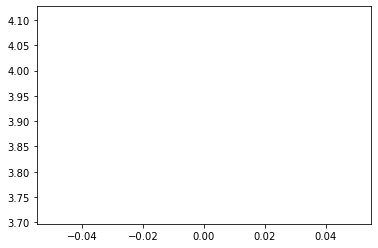

In [72]:
import matplotlib.pyplot as plt
plt.plot(loss_list)